## **University of Illinois Chicago**
CS 418 - Fall 2024 Team 5

## **Data-Driven Course Insights: Predicting Grade Trends**

## **Authors:**
| **Name**  | **Email** | **Github Handle** |
|---|---|---|
| Arlette Diaz | adiaz218@uic.edu | adiaz218 |
| Marianne Hernandez | mhern85@uic.edu | marhern19 |
| Nandini Jirobe | njiro2@uic.edu | nandinijirobe |
| Sharadruthi Muppidi | smuppi2@uic.edu | sharadruthi-uic |
| Sonina Mut | smut3@uic.edu | snina22 |
| Yuting Lu | lyuti@uic.edu | yutinglu103 |

**Github Repository Link: https://github.com/cs418-fa24/project-check-in-team-5/blob/main/final_project.ipynb**

## **Project Description**

This project is to predict course grade distributions and popularity rankings for upcoming semesters, enabling students to make informed decisions about their class selections. By shifting the focus from individual grade predictions to overall course outcomes, the project provides insights into course grading trends and demand. It uses clustering to rank courses based on student performance and popularity, and topic-based grouping to help students discover courses aligned with their interests, factoring in professor expertise and class attributes. This data-driven tool uncovers hidden patterns, aiding both students and academic planning.

## **Project Update**

In addition to the above, we have decided to include data from ME and IE courses and instructors to compare how both departments perfromed pre-covid, during covid and post-covid. We initally planned on including data from student course evaluations that are collected by the university at the end of each semester, however, we were not permitted access to that data. Hence we decided to simply move forward with the data collected from Google Scholar, Grade Distribution, Rate My Professor, and Course Scheduler. 

In [ ]:
import sys
python_loc = sys.executable

!{python_loc} -m pip install pandas
!{python_loc} -m pip install scikit-learn
!{python_loc} -m pip install matplotlib
!{python_loc} -m pip install seaborn

In [32]:
# import useful libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

### **Part 1: Load Datasets**

In [33]:
# Grade distribution data 
cs_grades = pd.read_csv('uic_GD_CS_14_24.csv')
meie_grades = pd.read_csv('uic_GD_MEIE_14_24.csv')

# Rate My Professor Data
cs_rmp = pd.read_csv('uic_RMP_CS_14_24.csv')
meie_rmp = pd.read_csv('CS418_Team5_DataSet - RMP_MEIE_14_24.csv')

# Google Scholar Data
cs_gs = pd.read_csv('CS418_Team5_DataSet - GS_CS_14_24.csv')
meie_gs = pd.read_csv('CS418_Team5_DataSet - GS_MEIE_14_24.csv')

# Lecture Data
cs_lectures = pd.read_csv('uic_CS_lectures_all_semesters.csv')
me_lectures = pd.read_csv('uic_ME_lectures_all_semesters.csv')
ie_lectures = pd.read_csv('uic_IE_lectures_all_semesters.csv')

# Course Description Data
cs_descrip = pd.read_csv('CS418_Team5_DataSet - CS_Descrip.csv')

### **Part 2: Data Cleaning**

#### **Dataset 1 - Grade Distribution**

In [34]:
# Grade distribution data cleaning
# Drop columns where all values are zero
cs_grades = cs_grades.loc[:, (cs_grades != 0).any(axis=0)]
meie_grades = meie_grades.loc[:, (meie_grades != 0).any(axis=0)]

# Drop rows where CRS TITLE (course title) contains "research" or "seminar" (case-insensitive)
cs_grades = cs_grades[~cs_grades['CRS TITLE'].str.contains("research|seminar", case=False, na=False)]
meie_grades = meie_grades[~meie_grades['CRS TITLE'].str.contains("research|seminar", case=False, na=False)]

# Convert all numeric columns to integers or floats
for col in cs_grades.columns:
    cs_grades[col] = pd.to_numeric(cs_grades[col], errors='ignore')

for col in meie_grades.columns:
    meie_grades[col] = pd.to_numeric(meie_grades[col], errors='ignore')

# Save the cleaned data to a new CSV file
cs_grades.to_csv("uic_GD_CS_14_24.csv", index=False)
meie_grades.to_csv("uic_GD_MEIE_14_24.csv", index=False)

C:\Users\nandi\AppData\Local\Temp\ipykernel_24260\2082822981.py:12: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  cs_grades[col] = pd.to_numeric(cs_grades[col], errors='ignore')
C:\Users\nandi\AppData\Local\Temp\ipykernel_24260\2082822981.py:15: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  meie_grades[col] = pd.to_numeric(meie_grades[col], errors='ignore')


#### **Dataset 2.1 - Rate My Professor - computer Science Department**

This cleaning data shows the result of joining two files: a CS grade distribution file (uic_GD_CS_14_24.csv), which contains course details and instructors and a Rate My Professors (RMP) file (uic_RMP_CS_14_24.csv), which includes ratings and the number of reviews for each instructor. Each row represents a record of the course titled along with information about instructors and their ratings.

In [35]:
cs_grades.rename(columns={'Primary Instructor': 'Instructor'}, inplace=True)

# Filter for courses
cs_grades = cs_grades[cs_grades['CRS NBR'].between(100, 599)]

merged_cs_data = pd.merge(cs_grades, cs_rmp, on='Instructor', how='left')

# Fill missing values with "N/A" for NULL columns
merged_cs_data['Rating'] = merged_cs_data['Rating'].fillna("N/A")
merged_cs_data['Num Reviews'] = merged_cs_data['Num Reviews'].fillna("N/A")
merged_cs_data[['CRS SUBJ CD', 'CRS TITLE', 'Instructor']] = merged_cs_data[['CRS SUBJ CD', 'CRS TITLE', 'Instructor']].fillna("N/A")

# Select relevant columns and sort by course number (CRS NBR)
result_data = merged_cs_data[['CRS SUBJ CD', 'CRS NBR', 'CRS TITLE', 'Instructor', 'Rating', 'Num Reviews']]
result_data = result_data.sort_values(by=['CRS NBR'])

# print(tabulate(result_data, headers='keys', tablefmt='fancy_grid', showindex=False))
print(result_data.head(20).to_string(index=False))

CRS SUBJ CD  CRS NBR                    CRS TITLE              Instructor Rating Num Reviews
         CS      100 Discovering Computer Science            Reed, Dale F    3.5       128.0
         CS      100 Discovering Computer Science          Parker, Kendal    N/A         N/A
         CS      100 Discovering Computer Science         Kidane, Ellen G    1.9       108.0
         CS      100 Discovering Computer Science            Reed, Dale F    3.5       128.0
         CS      100 Discovering Computer Science Reckinger, Shanon Marie    2.9        98.0
         CS      100 Discovering Computer Science          Parker, Kendal    N/A         N/A
         CS      100 Discovering Computer Science         Kidane, Ellen G    1.9       108.0
         CS      100 Discovering Computer Science            Reed, Dale F    3.5       128.0
         CS      100 Discovering Computer Science            Bell, John T    2.5       117.0
         CS      100 Discovering Computer Science            Bell, Joh

#### **Dataset 2.2 - Rate My Professor - Mechanical & Industrial Engineering Department**

This cleaning data shows the result of joining two files: a MEIE grade distribution file(uic_GD_MEIE_14_24.csv), which contains course details and instructors and a Rate My Professors (RMP) file(CS418_Team5_DataSet - RMP_MEIE_14_24.csv), which includes ratings and the number of reviews for each instructor. Each row represents a record of the course titled along with information about instructors and their ratings.

In [36]:
meie_grades.rename(columns={'Primary Instructor': 'Instructor'}, inplace=True)

# Filter for courses
meie_grades = meie_grades[meie_grades['CRS NBR'].between(100, 599)]

merged_meie_data = pd.merge(meie_grades, meie_rmp, on='Instructor', how='left')

# Fill missing values with "N/A" for Null columns
merged_meie_data['Rating'] = merged_meie_data['Rating'].fillna("N/A")
merged_meie_data['Num Reviews'] = merged_meie_data['Num Reviews'].fillna("N/A")
merged_meie_data[['CRS SUBJ CD', 'CRS TITLE', 'Instructor']] = merged_meie_data[['CRS SUBJ CD', 'CRS TITLE', 'Instructor']].fillna("N/A")

# Select relevant columns then sort them by course number
result_data = merged_meie_data[['CRS SUBJ CD', 
                           'CRS NBR', 
                           'CRS TITLE', 
                           'Instructor', 
                           'Rating', 
                           'Num Reviews']]
result_data = result_data.sort_values(by=['CRS NBR'])

# print(tabulate(result_data, headers='keys', tablefmt='fancy_grid', showindex=False))
print(result_data.head(20).to_string(index=False))

CRS SUBJ CD  CRS NBR                      CRS TITLE           Instructor Rating Num Reviews
         ME      118 Energy for Sustainable Society Alonso, Matthew Paul    N/A         N/A
         IE      118 Energy for Sustainable Society Alonso, Matthew Paul    N/A         N/A
         IE      201          Financial Engineering     Haghighi, Azadeh    4.8           6
         IE      201          Financial Engineering     Darabi, Houshang    3.3          28
         IE      201          Financial Engineering     Haghighi, Azadeh    4.8           6
         IE      201          Financial Engineering     Darabi, Houshang    3.3          28
         IE      201          Financial Engineering           Hu, Mengqi    2.2          12
         IE      201          Financial Engineering      Anahideh, Hadis    2.5           4
         IE      201          Financial Engineering   Banerjee, Prashant    1.8          10
         IE      201          Financial Engineering     Darabi, Houshang    3.3 

#### **Dataset 3 - Class Scheduler Data**

In [37]:
# Function to determine the time of day
def get_time_of_day(start_time):
    if 5 <= start_time.hour < 12:
        return "morning"
    elif 12 <= start_time.hour < 17:
        return "afternoon"
    else:
        return "evening"

# Function to calculate class duration in minutes
def calculate_duration(start_time, end_time):
    duration = end_time - start_time
    return duration.total_seconds() / 60  # Convert seconds to minutes

# All cs lectures
# Lists to store calculated values
times_of_day = []
durations = []

for time_range in cs_lectures['Time']:
    try:
        # Split the time range (e.g., "08:00 AM - 09:15 AM")
        start_str, end_str = time_range.split(" - ")
        
        # Convert to datetime objects
        start_time = datetime.strptime(start_str.strip(), "%I:%M %p")
        end_time = datetime.strptime(end_str.strip(), "%I:%M %p")
        
        # Determine time of day and calculate duration
        times_of_day.append(get_time_of_day(start_time))
        durations.append(calculate_duration(start_time, end_time))
        
    except Exception as e:
        # Handle any parsing errors by setting defaults
        times_of_day.append("unknown")
        durations.append(None)

# Assign the lists directly to the new columns
cs_lectures['Time of Day'] = times_of_day
cs_lectures['Duration of Class (minutes)'] = durations

unwanted_columns = ['Morning', 'Afternoon', 'Evening', 'Duration of Class']
cs_lectures.drop(columns=unwanted_columns, errors='ignore', inplace=True)

cs_lectures.to_csv("uic_CS_lectures_all_semesters.csv", index=False)

# All me lectures
# Lists to store calculated values
times_of_day = []
durations = []

for time_range in me_lectures['Time']:
    try:
        # Split the time range (e.g., "08:00 AM - 09:15 AM")
        start_str, end_str = time_range.split(" - ")
        
        # Convert to datetime objects
        start_time = datetime.strptime(start_str.strip(), "%I:%M %p")
        end_time = datetime.strptime(end_str.strip(), "%I:%M %p")
        
        # Determine time of day and calculate duration
        times_of_day.append(get_time_of_day(start_time))
        durations.append(calculate_duration(start_time, end_time))
        
    except Exception as e:
        # Handle any parsing errors by setting defaults
        times_of_day.append("unknown")
        durations.append(None)

# Assign the lists directly to the new columns
me_lectures['Time of Day'] = times_of_day
me_lectures['Duration of Class (minutes)'] = durations

unwanted_columns = ['Morning', 'Afternoon', 'Evening', 'Duration of Class']
me_lectures.drop(columns=unwanted_columns, errors='ignore', inplace=True)

me_lectures.to_csv("uic_ME_lectures_all_semesters.csv", index=False)

# All ie lectures
# Lists to store calculated values
times_of_day = []
durations = []

for time_range in ie_lectures['Time']:
    try:
        # Split the time range (e.g., "08:00 AM - 09:15 AM")
        start_str, end_str = time_range.split(" - ")
        
        # Convert to datetime objects
        start_time = datetime.strptime(start_str.strip(), "%I:%M %p")
        end_time = datetime.strptime(end_str.strip(), "%I:%M %p")
        
        # Determine time of day and calculate duration
        times_of_day.append(get_time_of_day(start_time))
        durations.append(calculate_duration(start_time, end_time))
        
    except Exception as e:
        # Handle any parsing errors by setting defaults
        times_of_day.append("unknown")
        durations.append(None)

# Assign the lists directly to the new columns
ie_lectures['Time of Day'] = times_of_day
ie_lectures['Duration of Class (minutes)'] = durations

unwanted_columns = ['Morning', 'Afternoon', 'Evening', 'Duration of Class']
ie_lectures.drop(columns=unwanted_columns, errors='ignore', inplace=True)

ie_lectures.to_csv("uic_IE_lectures_all_semesters.csv", index=False)

### **Part 3: Exploratory Data Analysis**

The data that we have collected is as follows (time frame is 2014-2024);

- Classes that are offered and what method they were offered as
- Number of students registered per class
- Grade distribution for classes (with more than 5 students enrolled) in CS, IE, and ME
- Rate my professor ratings for UIC professors in CS, IE, and ME
- Google Scholar information for UIC professors in CS, IE, and ME

Some issues that we have are;

- Some professors do not have their Google Scholar pages set up with their interests, as well as their RMP pages have little to no ratings
- Classes are not always offered for each semester/each year
- Grade distributions are only shown for courses with more than 5 students
- Online courses were only offered after the COVID pandemic, so we have only 3-4 years of data comparing online vs in-person course performance
- Not all students give a review on RMP

Our preliminary assumptions include;

- Since not all students give a review on RMP, these reviews might be biased (students unsatisfied with grades vs students who performed well)
- Grade distributions for the first year of COVID are lower than previous semesters
- IE and ME online courses are not offered as much as CS courses are
- Popular professors have the highest grade distribution


In [38]:
cs_rmp['Num Reviews'] = pd.to_numeric(cs_rmp['Num Reviews'], errors='coerce')
meie_rmp['Num Reviews'] = pd.to_numeric(meie_rmp['Num Reviews'], errors='coerce')

print(f"RMP: Total number of CS professors: {len(cs_rmp)}")
print(f"RMP: Number of CS professors with ratings: {cs_rmp['Rating'].notna().sum()}")
print(f"RMP: Number of CS professors without ratings: {cs_rmp['Rating'].isna().sum()}")

print(f"\nRMP: Total number of ME+IE professors: {len(meie_rmp)}")
print(f"RMP: Number of ME+IE professors with ratings: {meie_rmp['Rating'].notna().sum()}")
print(f"RMP: Number of ME+IE professors without ratings: {meie_rmp['Rating'].isna().sum()}")

print("\n=== Rating Statistics RMP For CS ===")
rating_stats = cs_rmp['Rating'].describe()
print(rating_stats)

print("\n=== Rating Statistics RMP For ME+IE ===")
rating_stats = meie_rmp['Rating'].describe()
print(rating_stats)

print("\nTop 5 Highest Rated CS Professors (minimum 5 reviews):")
top_rated = cs_rmp[cs_rmp['Num Reviews'] >= 5].nlargest(5, 'Rating')
print(top_rated[['Instructor', 'Rating', 'Num Reviews']])

print("\nTop 5 Most Reviewed CS Professors:")
most_reviewed = cs_rmp.nlargest(5, 'Num Reviews')
print(most_reviewed[['Instructor', 'Rating', 'Num Reviews']])

print("\nTop 5 Highest Rated ME+IE Professors (minimum 5 reviews):")
top_rated = meie_rmp[meie_rmp['Num Reviews'] >= 5].nlargest(5, 'Rating')
print(top_rated[['Instructor', 'Rating', 'Num Reviews']])

print("\nTop 5 Most Reviewed ME+IE Professors:")
most_reviewed = meie_rmp.nlargest(5, 'Num Reviews')
print(most_reviewed[['Instructor', 'Rating', 'Num Reviews']])

RMP: Total number of CS professors: 112
RMP: Number of CS professors with ratings: 84
RMP: Number of CS professors without ratings: 28

RMP: Total number of ME+IE professors: 70
RMP: Number of ME+IE professors with ratings: 51
RMP: Number of ME+IE professors without ratings: 19

=== Rating Statistics RMP For CS ===
count    84.000000
mean      3.469048
std       1.010067
min       1.000000
25%       2.675000
50%       3.500000
75%       4.300000
max       5.000000
Name: Rating, dtype: float64

=== Rating Statistics RMP For ME+IE ===
count    51.000000
mean      3.366667
std       1.148855
min       1.000000
25%       2.700000
50%       3.400000
75%       4.100000
max       5.000000
Name: Rating, dtype: float64

Top 5 Highest Rated CS Professors (minimum 5 reviews):
                         Instructor  Rating  Num Reviews
24  Ganchinho de Pina, Luis Gabriel     5.0         29.0
55                    Medya, Sourav     5.0          7.0
2   Bello Lander, Gonzalo Alejandro     4.9        11

In [39]:
grade_cols = ['A', 'B', 'C', 'D', 'F']

print("\n=== Grade Distribution Statistics For CS ===")

cs_grades['total_students'] = cs_grades['A'] + cs_grades['B'] + cs_grades['C'] + cs_grades['D'] + cs_grades['F']
cs_grades['pass_rate'] = (cs_grades['A'] + cs_grades['B'] + cs_grades['C']) / cs_grades['total_students']
cs_grades['gpa'] = (4*cs_grades['A'] + 3*cs_grades['B'] + 2*cs_grades['C'] + cs_grades['D']) / cs_grades['total_students']
cs_grades['course_code'] = cs_grades['CRS SUBJ CD'] + cs_grades['CRS NBR'].astype(str)

print("\nTop 5 Courses by GPA (minimum 20 students):")
top_gpa = cs_grades[cs_grades['total_students'] >= 20].nlargest(5, 'gpa')
print(top_gpa[['course_code', 'CRS TITLE', 'gpa', 'total_students']])

print("\nBottom 5 Courses by GPA (minimum 20 students):")
bottom_gpa = cs_grades[cs_grades['total_students'] >= 20].nsmallest(5, 'gpa')
print(bottom_gpa[['course_code', 'CRS TITLE', 'gpa', 'total_students']])

# Semester comparison
print("\nAverage GPA by Semester:")
semester_stats = cs_grades.groupby('SEMESTER')['gpa'].agg(['mean', 'std', 'count'])
print(semester_stats)

# Course size analysis
cs_grades['class_size'] = cs_grades['total_students']
cs_grades['size_category'] = pd.cut(cs_grades['class_size'], 
                           bins=[0, 20, 50, 100, float('inf')],
                           labels=['Small (<20)', 'Medium (20-50)', 'Large (50-100)', 'Very Large (>100)'])

print("\nGrade Distribution by Class Size:")
size_grades = cs_grades.groupby('size_category')[grade_cols].mean()
print(size_grades)

print("\n=== Grade Distribution Statistics For ME+IE ===")

meie_grades['total_students'] = meie_grades['A'] + meie_grades['B'] + meie_grades['C'] + meie_grades['D'] + meie_grades['F']
meie_grades['pass_rate'] = (meie_grades['A'] + meie_grades['B'] + meie_grades['C']) / meie_grades['total_students']
meie_grades['gpa'] = (4*meie_grades['A'] + 3*meie_grades['B'] + 2*meie_grades['C'] + meie_grades['D']) / meie_grades['total_students']
meie_grades['course_code'] = meie_grades['CRS SUBJ CD'] + meie_grades['CRS NBR'].astype(str)

print("\nTop 5 Courses by GPA (minimum 20 students):")
top_gpa = meie_grades[meie_grades['total_students'] >= 20].nlargest(5, 'gpa')
print(top_gpa[['course_code', 'CRS TITLE', 'gpa', 'total_students']])


=== Grade Distribution Statistics For CS ===

Top 5 Courses by GPA (minimum 20 students):
    course_code                   CRS TITLE  gpa  total_students
15        CS377    Communication and Ethics  4.0              42
28        CS493            Special Problems  4.0              36
29        CS502       Computational Biology  4.0              26
295       CS594  Intro to Quantum Computing  4.0              30
381       CS506  Intro to Quantum Computing  4.0              21

Bottom 5 Courses by GPA (minimum 20 students):
     course_code                      CRS TITLE       gpa  total_students
802        CS113  Program Design I Law & Policy  1.548387              62
409        CS251                Data Structures  1.688235             170
1054       CS111               Program Design I  1.729730              74
1055       CS111               Program Design I  1.954545              66
803        CS141              Program Design II  1.964103             195

Average GPA by Semester:
 

C:\Users\nandi\AppData\Local\Temp\ipykernel_24260\708311507.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_grades = cs_grades.groupby('size_category')[grade_cols].mean()


In [40]:
print("\n=== Class Schedule Statistics For CS ===")

cs_lectures['Time'] = cs_lectures['Time'].fillna('ARRANGED')
cs_lectures['Days'] = cs_lectures['Days'].fillna('ARRANGED')
cs_lectures['Duration of Class (minutes)'] = pd.to_numeric(cs_lectures['Duration of Class (minutes)'], errors='coerce')

print(f"\nTotal number of course sections: {len(cs_lectures)}")
print(f"Number of unique courses: {cs_lectures['Course Code'].nunique()}")
print(f"Number of unique instructors: {cs_lectures['Instructor'].nunique()}")
print(f"Year range: {cs_lectures['Year'].min()} - {cs_lectures['Year'].max()}")
print(f"\nSemesters offered:")
print(cs_lectures['Semester'].value_counts())

print(cs_lectures['Time of Day'].value_counts())

time_counts = cs_lectures[cs_lectures['Time'] != 'ARRANGED']['Time'].value_counts().head(10)
print("\nMost common class times:")
print(time_counts)

print("\n=== Class Schedule Statistics For ME ===")

me_lectures['Time'] = me_lectures['Time'].fillna('ARRANGED')
me_lectures['Days'] = me_lectures['Days'].fillna('ARRANGED')
me_lectures['Duration of Class (minutes)'] = pd.to_numeric(me_lectures['Duration of Class (minutes)'], errors='coerce')

print(f"\nTotal number of course sections: {len(me_lectures)}")
print(f"Number of unique courses: {me_lectures['Course Code'].nunique()}")
print(f"Number of unique instructors: {me_lectures['Instructor'].nunique()}")
print(f"Year range: {me_lectures['Year'].min()} - {me_lectures['Year'].max()}")
print(f"\nSemesters offered:")
print(me_lectures['Semester'].value_counts())

print(me_lectures['Time of Day'].value_counts())

time_counts = me_lectures[me_lectures['Time'] != 'ARRANGED']['Time'].value_counts().head(10)
print("\nMost common class times:")
print(time_counts)

print("\n=== Class Schedule Statistics For IE ===")

ie_lectures['Time'] = ie_lectures['Time'].fillna('ARRANGED')
ie_lectures['Days'] = ie_lectures['Days'].fillna('ARRANGED')
ie_lectures['Duration of Class (minutes)'] = pd.to_numeric(ie_lectures['Duration of Class (minutes)'], errors='coerce')

print(f"\nTotal number of course sections: {len(ie_lectures)}")
print(f"Number of unique courses: {ie_lectures['Course Code'].nunique()}")
print(f"Number of unique instructors: {ie_lectures['Instructor'].nunique()}")
print(f"Year range: {ie_lectures['Year'].min()} - {ie_lectures['Year'].max()}")
print(f"\nSemesters offered:")
print(ie_lectures['Semester'].value_counts())

print(ie_lectures['Time of Day'].value_counts())

time_counts = ie_lectures[ie_lectures['Time'] != 'ARRANGED']['Time'].value_counts().head(10)
print("\nMost common class times:")
print(time_counts)



=== Class Schedule Statistics For CS ===

Total number of course sections: 2072
Number of unique courses: 110
Number of unique instructors: 153
Year range: 2014 - 2024

Semesters offered:
Semester
Spring    1002
Fall       950
Summer     120
Name: count, dtype: int64
Time of Day
afternoon    1227
morning       669
evening       117
unknown        59
Name: count, dtype: int64

Most common class times:
Time
02:00 PM - 03:15 PM    214
12:30 PM - 01:45 PM    205
03:30 PM - 04:45 PM    183
09:30 AM - 10:45 AM    165
11:00 AM - 12:15 PM    153
01:00 PM - 01:50 PM    120
02:00 PM - 02:50 PM    114
10:00 AM - 10:50 AM    114
12:00 PM - 12:50 PM     93
11:00 AM - 11:50 AM     86
Name: count, dtype: int64

=== Class Schedule Statistics For ME ===

Total number of course sections: 1223
Number of unique courses: 68
Number of unique instructors: 89
Year range: 2014 - 2024

Semesters offered:
Semester
Spring    628
Fall      552
Summer     43
Name: count, dtype: int64
Time of Day
afternoon    659
m

### **Part 4: Data Visualizations**

#### 1 Clustering Plot for Course Popularity and Success Rate

This scatter plot visualizes clusters of courses grouped by popularity and performance.
Each point represents a course, positioned based on two principal components derived
from ratings, average grades, and enrollment. Courses in Cluster 1, for example, tend
to have both high popularity and good performance, making them attractive options for students.
Clusters help identify course characteristics and patterns based on the selected metrics.


**Hypothesis:** If a student were to chose a popular course, they have a higher chance of performing better academically.


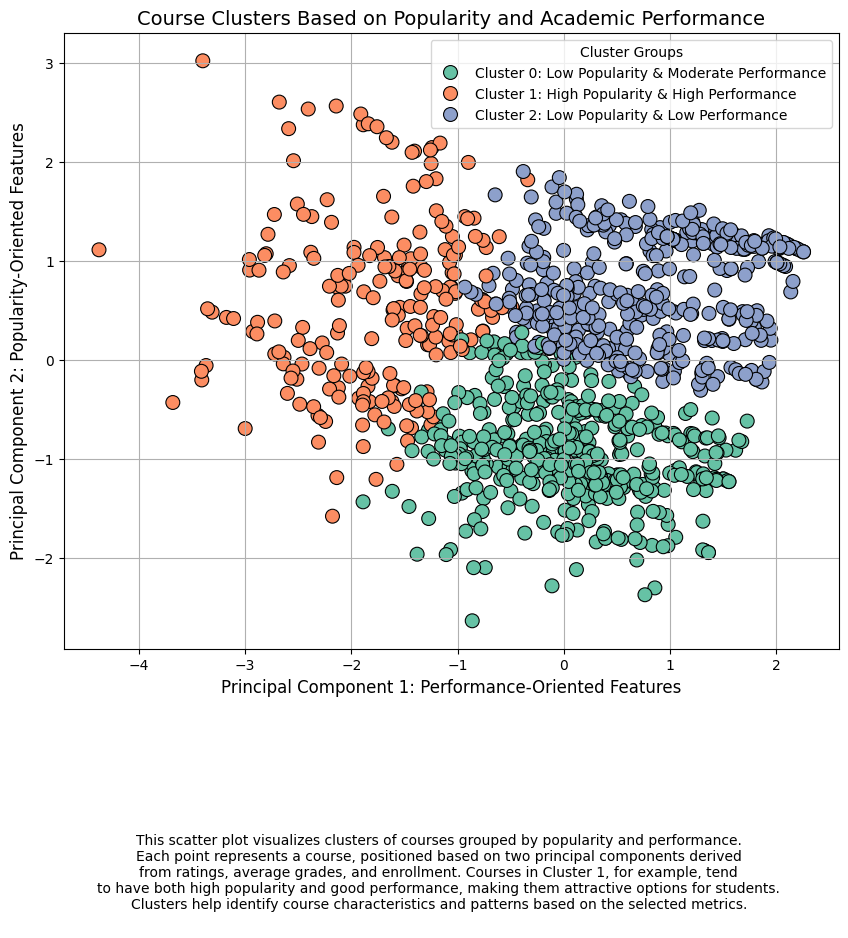

In [41]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
gd_cs_14_24 = cs_grades
rmp_cs_14_24 = cs_rmp
cs_descrip = cs_descrip

# Calculate average grade for each course in gd_cs_14_24
gd_cs_14_24['Total Grades'] = gd_cs_14_24[['A', 'B', 'C', 'D', 'F']].sum(axis=1)
gd_cs_14_24['Average Grade'] = (
    gd_cs_14_24['A'] * 4 + gd_cs_14_24['B'] * 3 + gd_cs_14_24['C'] * 2 + gd_cs_14_24['D'] * 1
) / gd_cs_14_24['Total Grades']

# Merge gd_cs_14_24 with rmp_cs_14_24 on 'Primary Instructor' and 'Instructor'
data = pd.merge(
    gd_cs_14_24,
    rmp_cs_14_24,
    left_on='Instructor',
    right_on='Instructor',
    how='left'
)

# Convert 'CRS NBR' in both dataframes to strings to enable merging
data['CRS NBR'] = data['CRS NBR'].astype(str)
cs_descrip['Course'] = cs_descrip['Course'].astype(str)

# Merge with cs_descrip on 'CRS SUBJ CD' and 'CRS NBR'
data = pd.merge(
    data,
    cs_descrip,
    left_on=['CRS SUBJ CD', 'CRS NBR'],
    right_on=['Course', 'Course Title'],
    how='left'
)

# Replace missing RMP ratings with the default value of 5
data['Rating'] = data['Rating'].fillna(5)

# Ensure there are no NaNs in selected features by filling remaining missing values with column means
features = data[['Average Grade', 'Rating', 'Grade Regs']].fillna(data[['Average Grade', 'Rating', 'Grade Regs']].mean())

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply KMeans and PCA
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(features_scaled)
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_scaled)

# Add clusters to the dataset for labeling
data['Cluster'] = clusters

import matplotlib.pyplot as plt
import seaborn as sns

# Plot clusters with additional information
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(
    x=features_2d[:, 0],
    y=features_2d[:, 1],
    hue=clusters,
    palette="Set2",
    s=100,
    edgecolor="black"
)

# Title and axis labels
plt.title("Course Clusters Based on Popularity and Academic Performance", fontsize=14)
plt.xlabel("Principal Component 1: Performance-Oriented Features", fontsize=12)
plt.ylabel("Principal Component 2: Popularity-Oriented Features", fontsize=12)

caption = """
This scatter plot visualizes clusters of courses grouped by popularity and performance.
Each point represents a course, positioned based on two principal components derived
from ratings, average grades, and enrollment. Courses in Cluster 1, for example, tend
to have both high popularity and good performance, making them attractive options for students.
Clusters help identify course characteristics and patterns based on the selected metrics.
"""

# Add legend with clearer descriptions
legend = plt.legend(title="Cluster Groups")
legend.texts[0].set_text("Cluster 0: Low Popularity & Moderate Performance")  # Example; adjust based on clusters
legend.texts[1].set_text("Cluster 1: High Popularity & High Performance")
legend.texts[2].set_text("Cluster 2: Low Popularity & Low Performance")

plt.figtext(0.5, -0.1, caption, ha="center", va="top", fontsize=10, wrap=True)

# Display the plot
plt.grid(True)
plt.show()



#### 2 Grade Distribution by Course Level

**Hypothesis:** Since students are more experienced in their major throughout their academic journey, they are able to perform better academically. 

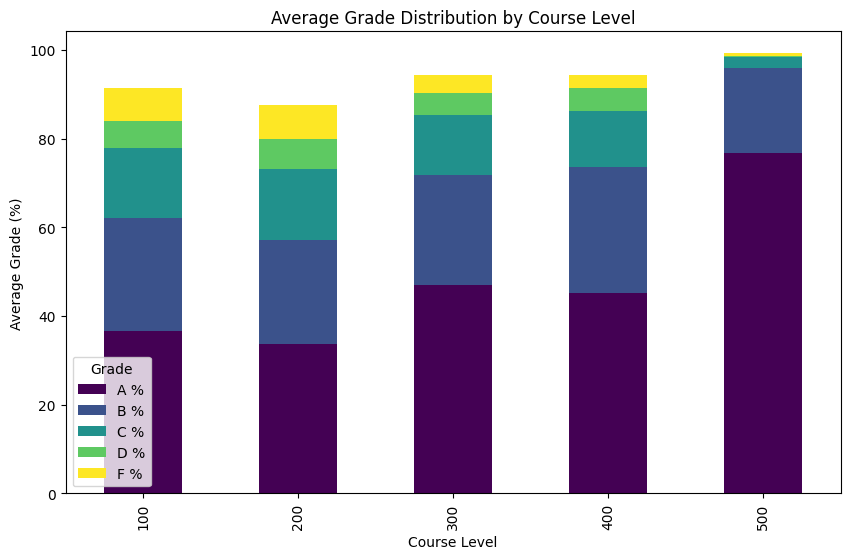

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load data
data = cs_grades
# Add a new column to categorize course numbers into levels (e.g., 100, 200, 300, etc.)
data['Course Level'] = (data['CRS NBR'] // 100) * 100

# Calculate total number of registered students per course
data['Total Registered'] = data[['A', 'B', 'C', 'D', 'F', 'W']].sum(axis=1)

# Calculate the grade distribution as a percentage of the total registered students
for grade in ['A', 'B', 'C', 'D', 'F']:
    data[f'{grade} %'] = (data[grade] / data['Total Registered']) * 100

# Aggregate average grade distribution by course level
grade_distribution = data.groupby('Course Level')[[f'{grade} %' for grade in ['A', 'B', 'C', 'D', 'F']]].mean()

# Plot grade distribution by course level
grade_distribution.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6))
plt.title("Average Grade Distribution by Course Level")
plt.xlabel("Course Level")
plt.ylabel("Average Grade (%)")
plt.legend(title="Grade")
plt.show()


#### 3 Withdrawal rate by course level <br>

**Hypothesis:** At the beginning of their educational career, students have a higher chance of dropping out of courses in comparison to down the line. 


C:\Users\nandi\AppData\Local\Temp\ipykernel_24260\674005309.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=withdrawal_rate_course_level.index, y=withdrawal_rate_course_level.values, palette="magma")


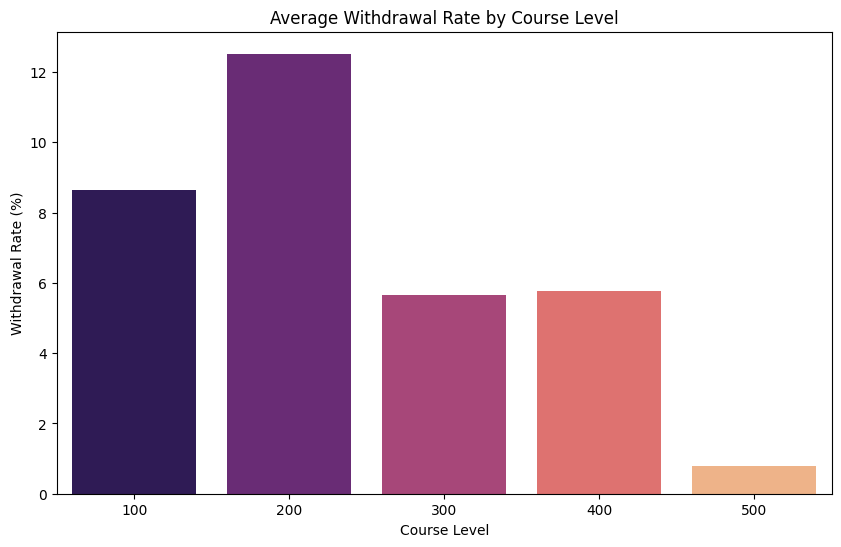

In [43]:
# Calculate withdrawal rate as a percentage of total registered students
data['Withdrawal Rate (%)'] = (data['W'] / data['Total Registered']) * 100

# Aggregate average withdrawal rate by course level
withdrawal_rate_course_level = data.groupby('Course Level')['Withdrawal Rate (%)'].mean().sort_index()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=withdrawal_rate_course_level.index, y=withdrawal_rate_course_level.values, palette="magma")
plt.title("Average Withdrawal Rate by Course Level")
plt.xlabel("Course Level")
plt.ylabel("Withdrawal Rate (%)")
plt.show()




#### 4 Grade distribution between semesters

**Hypothesis:** Students perform better or worse academically depending on the season, due to prior experience in previous courses or low motivation. 


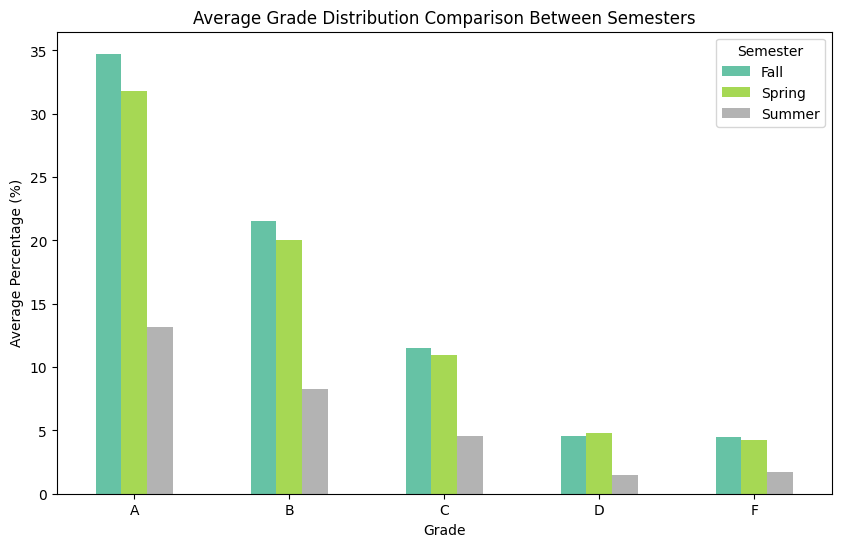

In [44]:
# Calculate average grade distribution for Fall and Spring semesters
semester_grades = data.groupby('SEMESTER')[['A', 'B', 'C', 'D', 'F']].mean()

# Plot side-by-side bar chart
semester_grades.T.plot(kind='bar', figsize=(10, 6), colormap="Set2")
plt.title("Average Grade Distribution Comparison Between Semesters")
plt.xlabel("Grade")
plt.ylabel("Average Percentage (%)")
plt.xticks(rotation=0)
plt.legend(title="Semester")
plt.show()


#### **5 Online and in-person course**

##### 5.1 Online Course Percentage by Year for Different Departments-line chart 

**Hypothesis:** After the pandemic, computer science courses are still able to be offered online compared to more hands-on majors such as Industrial or Mechanical Engineering.

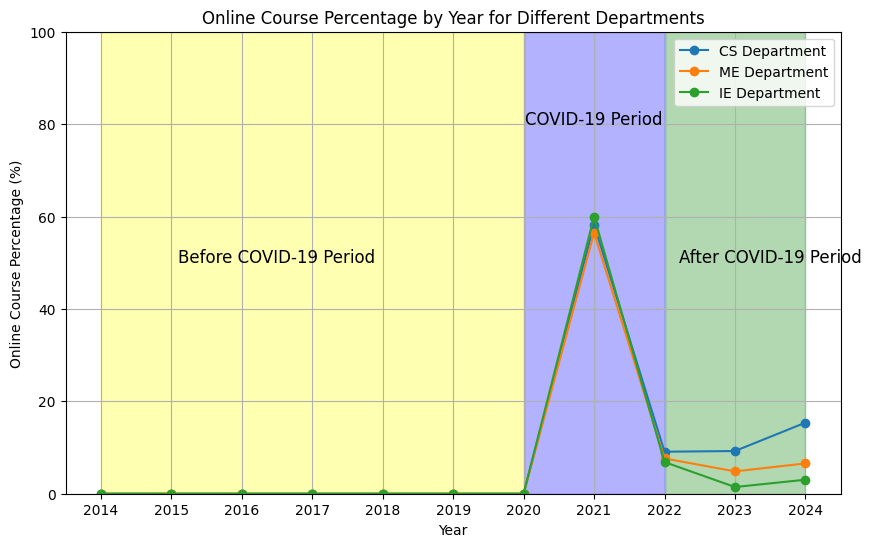

In [45]:
# Part 1
# Online Course Percentage by Year for Different Departments - line chart

# get data in CS department
cs_data = cs_lectures
# mark online course
cs_data['Is_Online'] = cs_data['Method'].str.contains('Online', case=False, na=False)
# calculate the ratio of online course for each year
cs_online_ratio_by_year = cs_data.groupby('Year')['Is_Online'].mean() * 100
# Create new table
cs_online_ratio_df = cs_online_ratio_by_year.reset_index()
cs_online_ratio_df.columns = ['Year', 'Online_Course_Percentage']
#print(cs_online_ratio_df)

# get data in IE department
ie_data = ie_lectures
# mark online course
ie_data['Is_Online'] = ie_data['Method'].str.contains('Online', case=False, na=False)
# calculate the ratio of online course for each year
ie_online_ratio_by_year = ie_data.groupby('Year')['Is_Online'].mean() * 100
# Create new table
ie_online_ratio_df = ie_online_ratio_by_year.reset_index()
ie_online_ratio_df.columns = ['Year', 'Online_Course_Percentage']
#print(ie_online_ratio_df)

# get data in ME department
me_data = me_lectures
# mark online course
me_data['Is_Online'] = me_data['Method'].str.contains('Online', case=False, na=False)
# calculate the ratio of online course for each year
me_online_ratio_by_year = me_data.groupby('Year')['Is_Online'].mean() * 100
# Create new table
me_online_ratio_df = me_online_ratio_by_year.reset_index()
me_online_ratio_df.columns = ['Year', 'Online_Course_Percentage']
#print(me_online_ratio_df)

plt.figure(figsize=(10, 6))
plt.plot(cs_online_ratio_df['Year'], cs_online_ratio_df['Online_Course_Percentage'], marker='o', linestyle='-', label='CS Department')
plt.plot(me_online_ratio_df['Year'], me_online_ratio_df['Online_Course_Percentage'], marker='o', linestyle='-', label='ME Department')
plt.plot(ie_online_ratio_df['Year'], ie_online_ratio_df['Online_Course_Percentage'], marker='o', linestyle='-', label='IE Department')

# add background
plt.axvspan(2014, 2020, color='yellow', alpha=0.3)
plt.text(2016.5, 50, 'Before COVID-19 Period', color='black', fontsize=12, ha='center')
plt.axvspan(2020, 2022, color='blue', alpha=0.3)
plt.text(2021, 80, 'COVID-19 Period', color='black', fontsize=12, ha='center')
plt.axvspan(2022, 2024, color='green', alpha=0.3)
plt.text(2023.5, 50, 'After COVID-19 Period', color='black', fontsize=12, ha='center')


plt.title('Online Course Percentage by Year for Different Departments')
plt.xlabel('Year')
plt.ylabel('Online Course Percentage (%)')

plt.xticks(range(2014, 2025))
plt.ylim(0, 100)

plt.legend()
plt.grid(True)
plt.show()


Finding1: Changes in Online Course Proportion:

1. Before COVID-19 Period, the proportion of online courses across all departments was nearly 0%, indicating that online teaching was not a primary mode of instruction before the pandemic.  
2. During COVID-19 Period, the proportion of online courses in all departments suddenly increased sharply, reaching nearly 100%.  
3. After COVID-19 Period, the proportion of online courses dropped significantly and stabilized. This indicates that after the pandemic, some courses returned to in-person instruction, although some habits of online teaching might have remained, especially in the CS department, which still had a relatively high proportion of online courses in 2023-2024.  
   
Finding2: Differences Among Departments:

1. During the COVID-19 period, the proportion of online courses was similar across all departments, indicating that under special circumstances, all disciplines transitioned to online teaching.  
2. After the the COVID-19 period, we can see that the CS department (blue line) retained more online courses, while the ME and IE departments largely returned to nearly 0% online courses.

Finding: Most of the online courses are concentrated in the summer semester after COVID-19 for every department.

### **Part 5: Machine Learning Analysis**

#### *Model Used:*
For the analysis of grade distributions, a **Random Forest Regressor** model was employed. This model predicts the distribution of grades (A, B, C, D, F) based on features such as **Rating**, **Num Reviews**, **Class Size**, and **Semester Encoded**. To handle the multi-output nature of the problem (multiple grade categories), a **MultiOutputRegressor** was utilized, which enables the prediction of all grade categories simultaneously.

#### *Baseline Comparison:*
To evaluate the model's performance, a baseline comparison was conducted by predicting the mean (or median) grade distribution for all observations. This baseline allows us to assess whether the **Random Forest** model performs better than a simple naive approach, where each grade category is predicted as the mean value for that category.

- **Baseline Model**: The baseline model predicts the mean grade distribution for each grade category (A, B, C, D, F) across all observations. 
   - The **Mean Squared Error (MSE)** for the baseline model would be calculated by predicting the mean for each grade category and measuring the variance from the actual values.

#### *Model Performance:*
After training the **Random Forest Regressor** model on the training data, the following **Mean Squared Error (MSE)** values were obtained for each grade category:

- *MSE for Each Grade Category*:
  - *A*: 196.02
  - *B*: 83.28
  - *C*: 37.89
  - *D*: 12.90
  - *F*: 17.66

These values represent how well the model's predictions align with the actual grade distributions. Lower MSE values indicate better prediction accuracy for that grade category. The model performed best in predicting **Grade D** (MSE = 12.90) and **Grade F** (MSE = 17.66), while it struggled more with **Grade A** (MSE = 196.02), which is likely due to fewer students receiving an A and therefore less variance in the data for that grade.

#### *Interpretation of Results:*

- *Accuracy of Predictions*: The model is most accurate for predicting *Grade D* and *Grade F*, with low MSE values for these categories. The model's performance drops for higher grades like *Grade A* and *Grade B*, with *Grade A* predictions showing the highest MSE. This suggests that predicting *Grade A* is more challenging, potentially due to the smaller number of students achieving this grade.

- *Feature Importance*: The model's *feature importance* analysis revealed that *Class Size* was the most influential factor in determining grade distributions, with an importance score of *0.79*. Other features such as *Num Reviews* (0.11), *Rating* (0.08), and *Semester Encoded* (0.015) were less important in influencing grade distribution.

   - *Class Size*: The large effect of class size on grade distribution suggests that larger classes might have different grading dynamics or scaling practices, which could influence the overall grade distribution.
   
   - *Num Reviews* and *Rating*: While *Num Reviews* and *Rating* influence the grade distribution to some extent, their impact is less significant compared to class size. These features may reflect the overall student experience, but their direct effect on the grades is less pronounced.

#### *Baseline vs. Model:*
A comparison between the baseline model (predicting the mean for each grade category) and the **Random Forest Regressor** model shows that the latter outperforms the baseline in predicting grade distributions. The **Random Forest** model consistently yields lower MSE values for each grade category, indicating its superior predictive performance compared to the baseline approach.

### *Visualizations and Insights:*

- *MSE for Each Grade*:
   A plot showing the **Mean Squared Error (MSE)** for each grade category helps visualize the model's performance. It highlights that **Grade D** and **Grade F** predictions are more accurate, while **Grade A** predictions are less accurate.

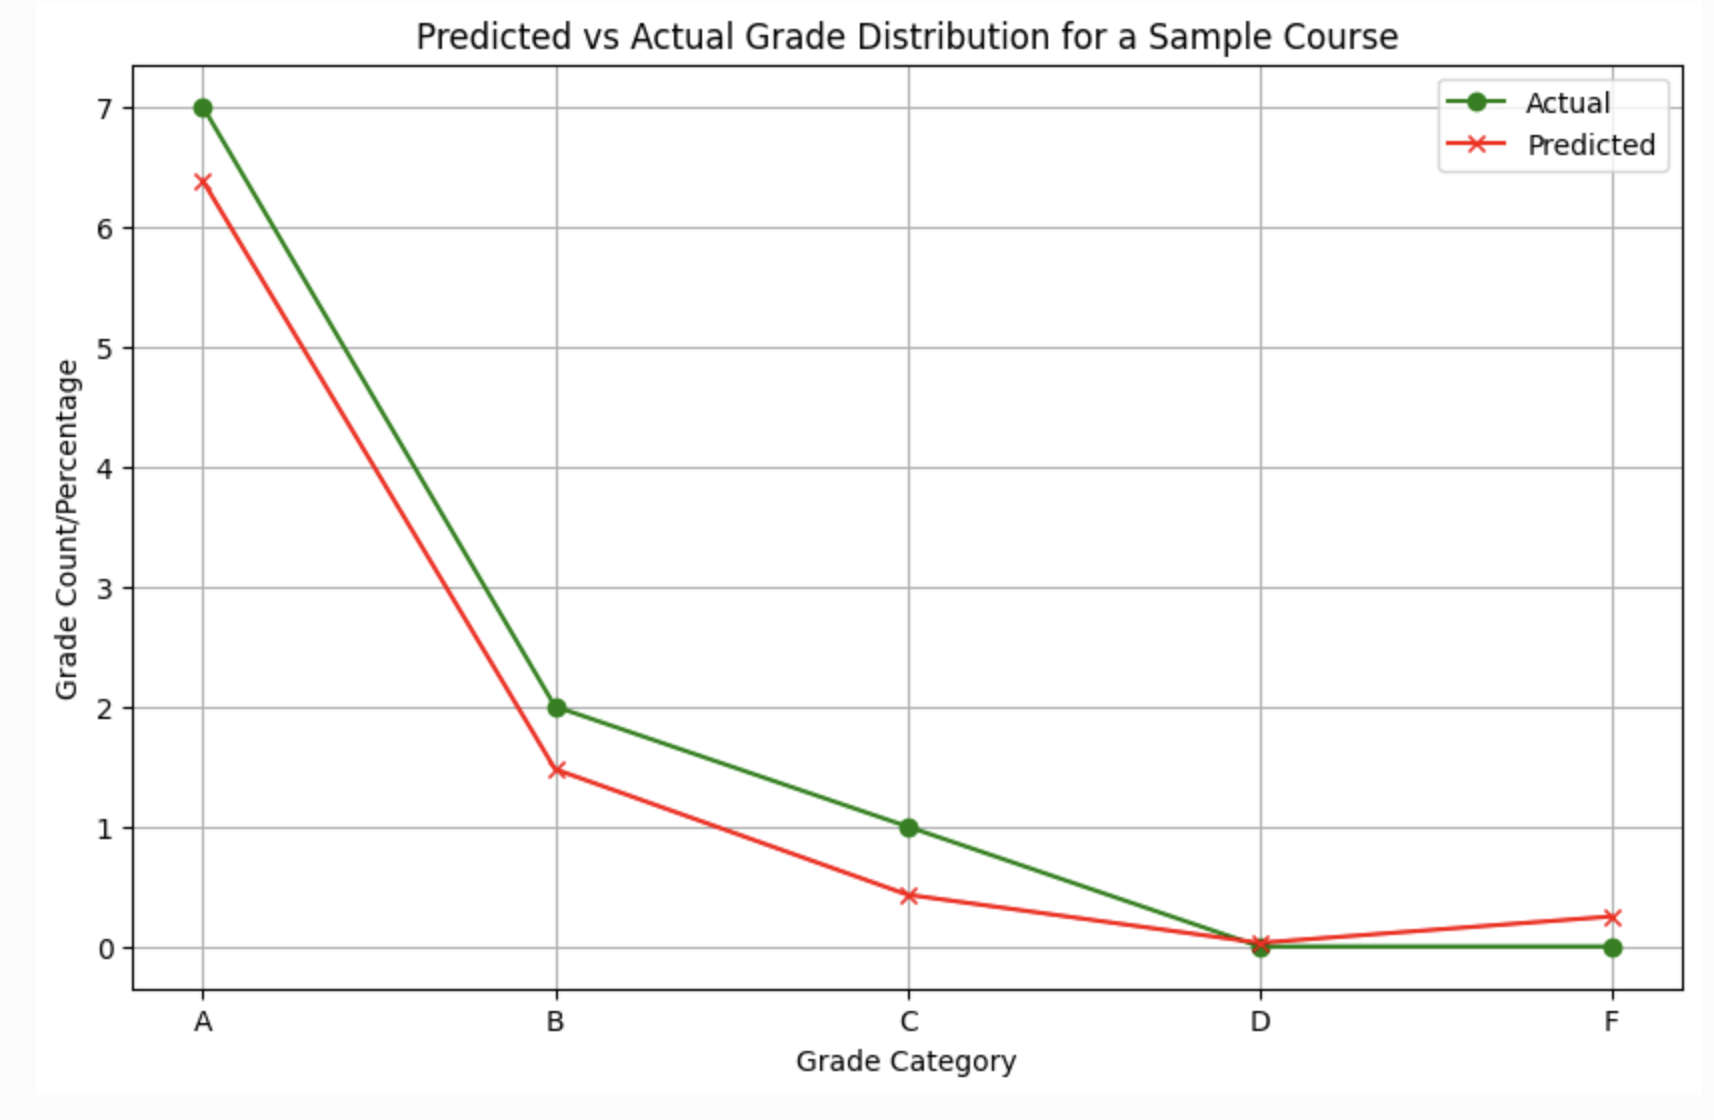

- *Predicted vs. Actual Grades*:
   A further visualization comparing the predicted vs. actual grade distributions for a sample course can be used to understand the model's prediction accuracy for specific cases. This visual comparison can reveal where the model tends to overestimate or underestimate certain grades.
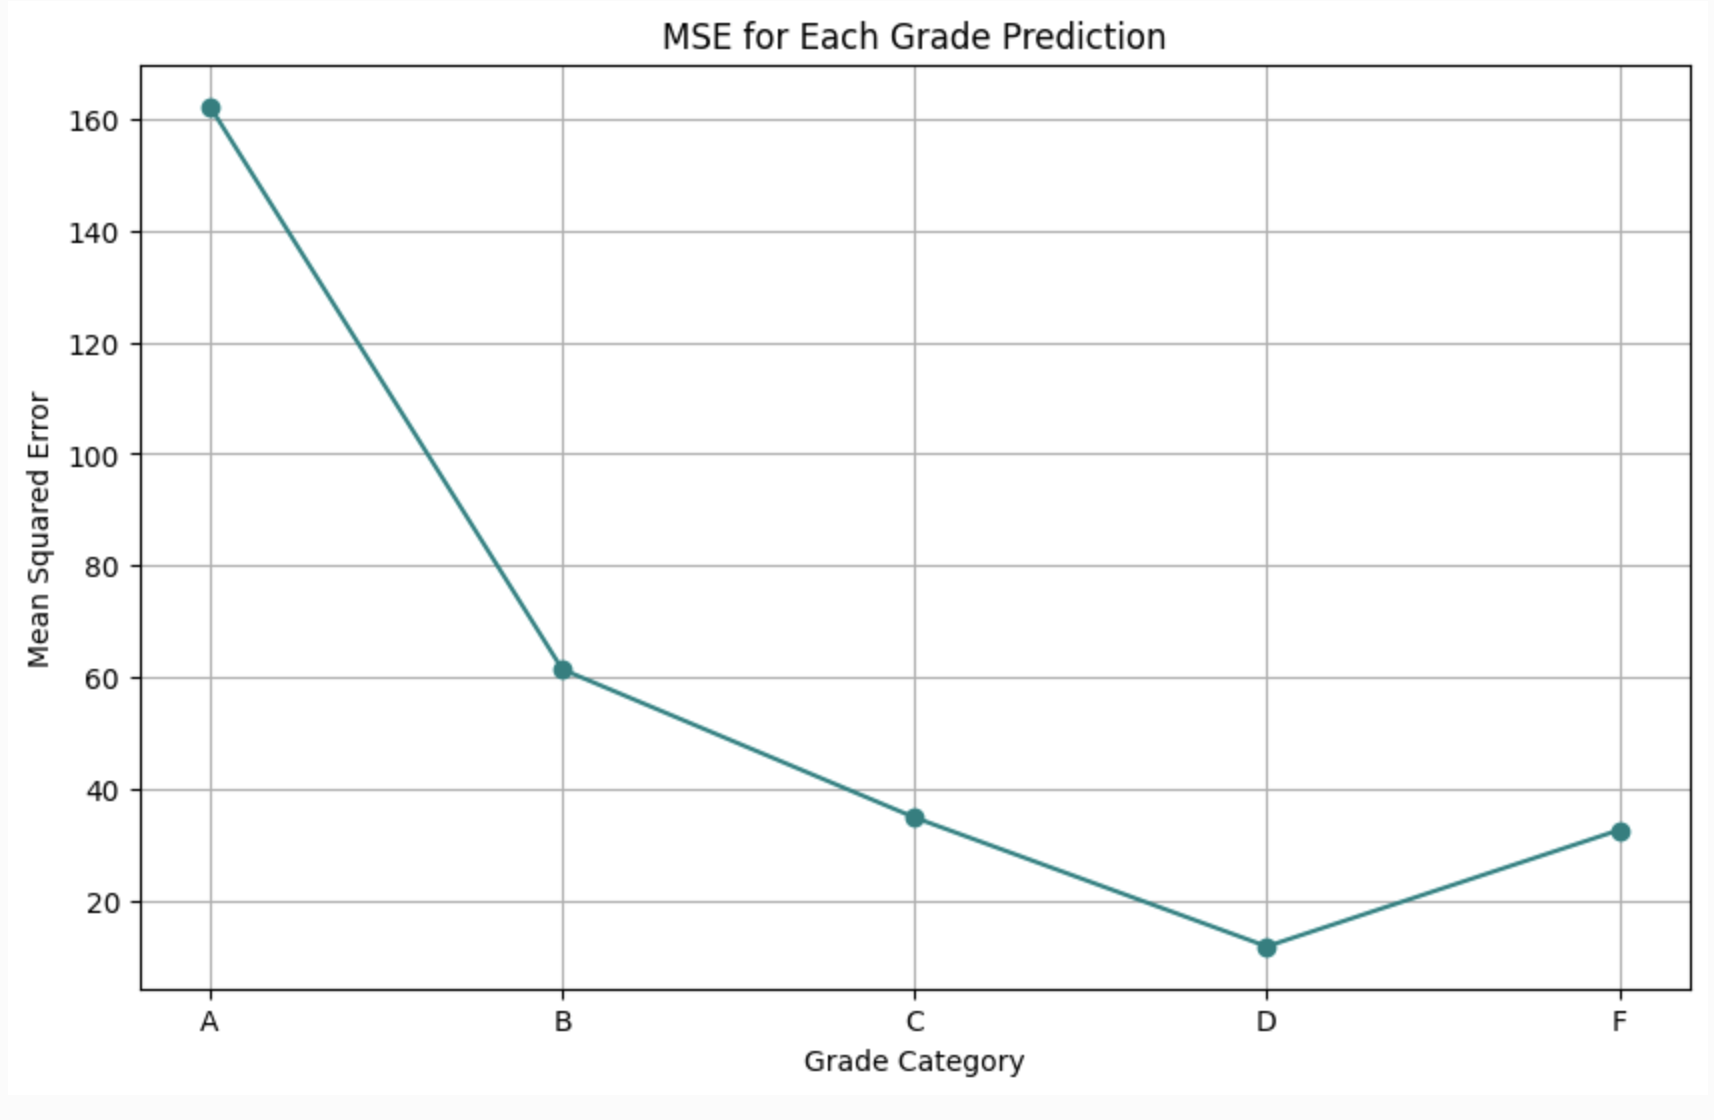


### *Conclusion:*
- The *Random Forest Regressor* model is effective in predicting grade distributions, with *Class Size* identified as the most influential feature. The model performs better than a simple baseline approach (predicting the mean for each grade category), especially for grades with larger distributions like *Grade D* and *Grade F*.
- The MSE values indicate that predictions for *Grade A* are more challenging due to the lower number of students achieving an A, while *Class Size* remains the primary factor influencing grade outcomes.
- This analysis demonstrates the potential of machine learning models in predicting grade distributions based on various course and instructor characteristics, which can help in understanding and potentially improving academic performance forecasting.

This analysis can be expanded further by exploring additional features, tuning the model, or experimenting with other machine learning algorithms for potentially better predictions.



Feature Statistics:
             Rating  Num Reviews   Class Size  Semester Encoded
count  1136.000000  1136.000000  1136.000000       1136.000000
mean      3.366699    45.959507    77.633803          0.639965
std       0.812191    43.064751    72.929497          0.615330
min       1.000000     0.000000    10.000000          0.000000
25%       2.700000    11.000000    28.000000          0.000000
50%       3.366699    25.000000    52.000000          1.000000
75%       4.000000    82.000000    97.250000          1.000000
max       5.000000   144.000000   440.000000          2.000000

Mean Squared Error for each grade category: [162.2491433   61.42415575  34.88534573  11.78439886  32.63805025]


C:\Users\nandi\AppData\Local\Temp\ipykernel_24260\1748208279.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=features.columns, y=feature_importances, palette="viridis")


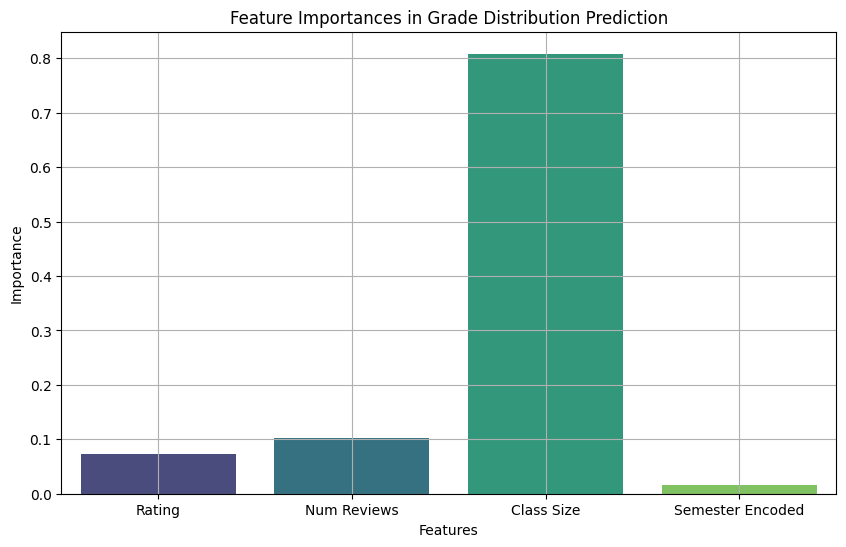

In [46]:
import pandas as pd

# Load the datasets
grade_data = cs_grades
rmp_data = cs_rmp
course_desc = cs_descrip

# Ensure proper formatting of CRS SUBJ CD and CRS NBR to create Course_Code
grade_data['Course_Code'] = grade_data['CRS SUBJ CD'].str.strip() + " " + grade_data['CRS NBR'].astype(str).str.zfill(3).str.strip()

# Function to clean and extract first and last names from "Last, First" format
def clean_instructor_name(name):
    parts = name.split(',')
    if len(parts) == 2:
        first_last = parts[1].strip() + ' ' + parts[0].strip()  # "First Last"
        return first_last
    return name.strip()

# Clean up instructor names in both grade data and RMP data
grade_data['Instructor Cleaned'] = grade_data['Instructor'].apply(clean_instructor_name)
rmp_data['Instructor Cleaned'] = rmp_data['Instructor'].apply(clean_instructor_name)

# Merge grade data with RMP data on Cleaned Instructor Name
merged_data = pd.merge(grade_data, rmp_data[['Instructor Cleaned', 'Rating', 'Num Reviews']], 
                       left_on='Instructor Cleaned', right_on='Instructor Cleaned', how='left')

# Clean up Course column in course_desc to match Course_Code format
course_desc['Course'] = course_desc['Course'].str.strip()

# Merge with course descriptions
merged_data = pd.merge(
    merged_data,
    course_desc[['Course', 'Course Title']],  # Use relevant columns from course_desc
    left_on='Course_Code',
    right_on='Course',
    how='left'
)

# Fill missing RMP ratings and reviews with appropriate values
merged_data['Rating'] = merged_data['Rating'].fillna(merged_data['Rating'].mean())
merged_data['Num Reviews'] = merged_data['Num Reviews'].fillna(0)

# Feature Engineering
merged_data['Class Size'] = merged_data['Grade Regs']  # Total registered students in the class
merged_data['Semester Encoded'] = pd.Categorical(merged_data['SEMESTER']).codes  # Encode semester as numeric

# Define features and target variables
features = merged_data[['Rating', 'Num Reviews', 'Class Size', 'Semester Encoded']]
target = merged_data[['A', 'B', 'C', 'D', 'F']]

# Feature Statistics (Summary)
print("\nFeature Statistics:\n", features.describe())

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize and train the model
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
model.fit(X_train, y_train)

# Predict on the test set
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')

# Display the MSE results
print("\nMean Squared Error for each grade category:", mse)

# Visualization: MSE for each grade category
'''import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(target.columns, mse, marker='o', color='teal')
plt.title("MSE for Each Grade Prediction")
plt.xlabel("Grade Category")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()'''

# Visualization: Predicted vs. Actual Grades for a sample of the test set
'''sample_index = 0  # Modify this index to check other test samples
plt.figure(figsize=(10, 6))
plt.plot(target.columns, y_test.iloc[sample_index], label="Actual", marker='o', color='green')
plt.plot(target.columns, y_pred[sample_index], label="Predicted", marker='x', color='red')
plt.title("Predicted vs Actual Grade Distribution for a Sample Course")
plt.xlabel("Grade Category")
plt.ylabel("Grade Count/Percentage")
plt.legend()
plt.grid()
plt.show()'''

# Feature Importance Visualization
import seaborn as sns
feature_importances = model.estimators_[0].feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=features.columns, y=feature_importances, palette="viridis")
plt.title("Feature Importances in Grade Distribution Prediction")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.grid()
plt.show()


## **Reflection**

**What is the hardest part of the project that you’ve encountered so far?**<br>
The hardest part of the project that we encountered was collecting the data. This stage took the longest as some of the data we were collecting did not allow using web scrapers and we had to manually collect all the data. For example, the google scholar and rate my professor data was all manually collected. 

**Note: When looking at the induvidual contributions please refer to the section below. We had a lot of commit issues using Git therefore we sometimes shared the code amongst each other and relied on one person to make all the changes**

<br>**What are your initial insights?**<br>
Our inital insights that there was a relationship between a professor's rate my professor rating, course level,  course size, format and the grade distribution. 

<br>**Are there any concrete results you can show at this point? If not, why not?**<br>
Yes we do have some concrete results to show at this point.

<br>**Going forward, what are the current biggest problems you’re facing?**<br>
We would still like to use the Google Scholar data to help train our model that will predict grade distributions. The way we were planning on doing this was by finding similarity between an instructor's research interests and the course description of a class they taught and use this data as a feature for the model. We attempted using the cosine similarity function to do this but achieved poor results. The biggest problem we have are facing right now is finding a better way to calculate this percentage. 

<br>**Do you think you are on track with your project? If not, what parts do you need to dedicate more time to?**<br>
Yes I do think we are on track to completing this project.

<br>**Given your initial exploration of the data, is it worth proceeding with your project, why? If not, how are you going to change your project and why do you think it’s better than your current results?**<br>
Yes! We think it is definitely worth proceeding with our project. We have made a lot of interesting insights from this data. We believe with a lot more time and effort, we will be able to gather more patterns in our data and develop a accurate machine learning model too. 



## **Roles/Coordination (important)**

**Arlette Diaz:** 
* Cleaned the grade distribution data set for Comupter Science classes
* Cleaned the grade distribution data set for MEIE classes
* Cleaned the lecutre data set for all classes (CS, IE, ME)

<br>**Marianne Hernandez:** 
* Scraped the data for Computer Science course offerings between Spring 2014 - Summer 2024
* Scraped the data for Mechanical Engineering course offerings between Spring 2014 - Summer 2024
* Scraped the data for Industrial Engineering course offerings between Spring 2014 - Summer 2024
* Converted data into .csv files for group to use after cleaning up and reorganizing relevant information
* Worked on EDA section

<br>**Nandini Jirobe:** 
* Collected Rate My Professor ratings for professors who taught Mechanical and Industrial Enginnering classes from 2014-2024
* Collected Rate My Professor ratings for professors in the Computer Science classes from 2014-2024
* Collected Google Scholar research interests of professors who taught Mechanical and Industrial Enginnering classes from 2014-2024
* Collected Google Scholar research interests of professors in the Computer Science classes from 2014-2024
* Collected course description data for computer science courses taught at UIC. 

<br>**Sharadruthi Muppidi:** 
* Worked on ML Model Training and Analysis (Part 5),  Worked on Visualizations ( Part 4: 1-4) 

<br>**Sonina Mut:** 
* Collected UIC Grade Distribution for professors who taught Mechanical and Industrial Enginnering classes from 2014-2024
* Collected UIC Grade Distribution for professors in the Computer Science classes from 2014-2024
* Collected Rate My Professor ratings for professors who taught Mechanical and Industrial Enginnering classes from 2014-2024
* Collected Rate My Professor ratings for professors in the Computer Science classes from 2014-2024
* Completed Data Clean, Dataset 2.1 for Rate My professor from 2014-2024
* Completed Data Clean, Dataset 2.2 for Rate My professor from 2014-2024

<br>**Yuting Lu:** 
* Came up with some data visualization ideas.
* Completed data visualizations 5

## **Next Steps**

* We are going to continue working on developing the performance of our machine learning model that can predict the grade distribution of a class. We plan on doing this by adding an additional column that contains percentages of how similar a professor's research background is to the course they teach.
* We will also train a machine learning model that can predict a professor's Rate My Professor rating based on the grade distribution
* We will know that we have achieved our goals when we have successfully trained a model that has decent accuracy rate. 